In [1]:
import matplotlib
matplotlib.use('TkAgg')
from matplotlib import pyplot as plt
import operator
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
%matplotlib inline

In [5]:
#获取数据
def getData(str1,str0):
    fr1=open(str1)
    fr0=open(str0)
    arrayOLines1 = fr1.readlines()  # 读取文件
    arrayOLines0 = fr0.readlines()
    # 特征矩阵
    dataMat1 = []
    dataMat0 = []
    # 男同学
    for line in arrayOLines1:
        line = line.strip()  # strip()去掉首尾空格
        listFromLine = line.split()  # 按空白字符分割成列表
        # string变float
        for i in range(len(listFromLine)):
            listFromLine[i] = np.float(listFromLine[i])
        # 加入特征矩阵
        dataMat1.append(listFromLine)
    # 女同学
    for line in arrayOLines0:
        line = line.strip()  # strip()去掉首尾空格
        listFromLine = line.split()  # 按空白字符分割成列表
        # string变float
        for i in range(len(listFromLine)):
            listFromLine[i] = np.float(listFromLine[i])
        # 加入特征矩阵
        dataMat0.append(listFromLine)
    return dataMat1, dataMat0


#k-近邻算法(输入的特征向量,男生训练集,女生训练集,k值)
#注意,传进来的必须已经归一化好了
def KJL(inX,dataMat1,dataMat0,k):
    dataMat1 = np.mat(dataMat1)
    dataMat0 = np.mat(dataMat0)
    # 用shape[0]读取训练集第一维的长度(行数即训练集实例数)
    dataSetRow1 = dataMat1.shape[0]
    dataSetRow0 = dataMat0.shape[0]
    # 用tile()将输入的特征向量重复成和训练集特征向量一样多的行
    # 变成2维,里面的维度重复1次,外面一层重复dataSetRowi次
    diffMat1 = np.tile(inX, (dataSetRow1, 1))
    diffMat0 = np.tile(inX, (dataSetRow0, 1))
    # 减去训练集特征向量矩阵得到存偏差的矩阵
    diffMat1 = diffMat1 - dataMat1
    diffMat0 = diffMat0 - dataMat0
    # 将减出来的偏差矩阵每个元素平方
    sqDiffMat1 = np.multiply(diffMat1, diffMat1)
    sqDiffMat0 = np.multiply(diffMat0, diffMat0)
    # 对行求和,表示这个实例和这行对应的训练集实例的L2范数的平方
    sqDistances1 = sqDiffMat1.sum(axis=1)
    sqDistances0 = sqDiffMat0.sum(axis=1)
    # 变成列表然后追加到一起,再变回mat对象
    sqDistances = sqDistances1.tolist()
    sqDistances.extend(sqDistances0.tolist())
    sqDistances = np.mat(sqDistances)
    sqDistances = [sqDistances[i, 0] for i in range(len(sqDistances))]
    sqDistances = np.array(sqDistances)
    # argsort()返回其从小到大排序的排序索引序列
    sortIndex = sqDistances.argsort()
    #空字典,用来存各个标签在前k邻居中出现的次数
    classCount={}
    #找前k个距离最近的,也就是排序下标从0~k-1的
    for i in range(k):
        # 暂存第i近(从0计数)训练集实例的标签,男生是1女生是0
        voteIlab = 1 if sortIndex[i] < dataSetRow1 else 0
        # 先取字典中以这个标签为key的value值,如果没有则返回0
        # 加上1作为以这个标签为key的value值
        classCount[voteIlab] = classCount.get(voteIlab, 0) + 1
    # 把classCount用items()方法变成可迭代对象传入
    # 用operator.itemgetter()方法定义一个函数给参数key,这个函数按1号域排序
    # 将reverse参数显示修正为True,表示降序排序(找频数最大的)
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1),reverse=True)
    # 排序好后,第0个对象就是要找的那个频率最高的实例的[标签,频率]了
    # 只返回标签
    return sortedClassCount[0][0]


#不同的特征,范围可能不同,作差得到的值可能差别很大
#如果它们的重要程度一样,显然不应如此
#可以将不同取值范围的特征值数值归一化到0~1之间
def autoNorm(dataMat):
    #下面参数0表示从列中取最大最小
    minVals=dataMat.min(0) #每列的最小值存到minVals里
    maxVals = dataMat.max(0)  # 每列的最大值存到maxVals里
    ranges = maxVals - minVals  # 每列最大最小值之差,存到ranges里
    newDataMat = np.zeros(np.shape(dataMat))  # 用来存归一化后的矩阵
    m = dataMat.shape[0]  # 取第0维即行数
    newDataMat = dataMat - np.tile(minVals, (m,1))
    # 把最小值重复m成m行,用原值减去
    newDataMat=newDataMat/np.tile(ranges,(m,1))
    #把减完的每个偏差值除以自己列最大和最小的差值
    return newDataMat,ranges,minVals


#为测试集归一化用的函数
def autoNormNew(dataMat,ranges,minVals):
    newDataMat = np.zeros(np.shape(dataMat)) #用来存归一化后的矩阵
    m=dataMat.shape[0] #取第0维即行数
    newDataMat = dataMat - np.tile(minVals, (m, 1))  # 把最小值重复m成m行,用原值减去
    newDataMat = newDataMat / np.tile(ranges, (m, 1))  # 把减完的每个偏差值除以最大和最小的差值
    return newDataMat  # 返回归一化之后的矩阵


#测试分类器效果(不用传参的函数称为"自包含的")
def datingClassTest(k=5):
    dataMat1, dataMat0 = getData('boynew.txt', 'girlnew.txt')
    tstMat1, tstMat0 = getData('boy.txt', 'girl.txt')
    # 注意!归一化不应把男女分开来做,否则得到的数据势必多携带了归一化的不同
    # 虽然这样的分类错误率高了不少,但这才是正常的
    # 试想如果不是训练集,而是完全不清楚标签的样本集,不可能分开归一化
    # 因为做kNN最后的目的就是在分类
    dataMat = dataMat1
    dataMat.extend(dataMat0)
    _, ranges, minVals = autoNorm(np.mat(dataMat))
    # 把男女再分割出来方便使用
    dataMat1 = autoNormNew(np.mat(dataMat1), ranges, minVals)
    dataMat0 = autoNormNew(np.mat(dataMat0), ranges, minVals)
    # 对测试集,要用训练集拿到的ranges和minVals对其归一化
    tstMat1 = autoNormNew(np.mat(tstMat1), ranges, minVals)
    tstMat0 = autoNormNew(np.mat(tstMat0), ranges, minVals)

    # 获得样本特征集的行数m
    m1 = tstMat1.shape[0]
    m0 = tstMat0.shape[0]
    errCount = 0.0  # 已经分类错误的样本数目,用小数是为了后面作除法得错误率方便
    # 对测试集的每个条目(样本集中前numTestVecs个样本)而言
    for i in range(m1):
        if KJL(tstMat1.tolist()[i], dataMat1, dataMat0, k) == 0:
            errCount += 1
    for i in range(m0):
        if KJL(tstMat0.tolist()[i], dataMat1, dataMat0, k) == 1:
            errCount += 1
    print("测试错误率是: %f" % (errCount / (m1 + m0)))


#对单个样本特征的归一化函数
def autoVec(dataVec,ranges,minVals):
    newDataVec = dataVec - minVals  # 用原值减去最小值
    newDataVec = newDataVec / ranges # 减完除以最大和最小的差值
    return newDataVec  # 返回归一化之后的样本


#绘图,在二维情况下展示kNN分类面
def MyPic(i,j,k=5):
    dataMat1,dataMat0=getData('boynew.txt','girlnew.txt')
    tstMat1,tstMat0=getData('boy.txt','girl.txt')
    #对训练集归一化
    dataMat = dataMat1
    dataMat.extend(dataMat0)
    _, ranges, minVals = autoNorm(np.mat(dataMat))
    dataMat1 = autoNormNew(np.mat(dataMat1), ranges, minVals)
    dataMat0 = autoNormNew(np.mat(dataMat0), ranges, minVals)
    ranges = ranges.tolist()[0]  # 转成list
    minVals = minVals.tolist()[0]
    if i == 0:
        start_i = 150
        end_i = 190
        xlab = 'Height'
    elif i == 1:
        start_i = 40
        end_i = 60
        xlab = 'Weight'
    elif i == 2:
        start_i = 35
        end_i = 42
        xlab = 'Shoe Size'
    if j == 0:
        start_j = 150
        end_j = 190
        ylab='Height'
    elif j==1:
        start_j=40
        end_j=60
        ylab='Weight'
    elif j == 2:
        start_j = 35
        end_j = 42
        ylab = 'Show Size'
    # 采样点
    x = np.arange(start_i, end_i, 0.2)
    y = np.arange(start_j, end_j, 0.2)
    x, y = np.meshgrid(x, y)
    x = x.reshape(1, -1)[0].tolist()
    y = y.reshape(1, -1)[0].tolist()
    Ftr1i = []  # 男生x
    Ftr1j = []  # 男生y
    Ftr0i = []  # 女生x
    Ftr0j = []  # 女生y
    # 针对i号和j号特征,构造新的ranges,minVals
    ranges = np.array([ranges[i], ranges[j]])
    minVals = np.array([minVals[i], minVals[j]])
    # 注意!对dataMat也要降维处理
    # 因为之前是3个特征的
    dataMat1 = dataMat1.tolist()
    dataMat1 = [[dataMat1[r][i], dataMat1[r][j]] for r in range(len(dataMat1))]
    dataMat0 = dataMat0.tolist()
    dataMat0 = [[dataMat0[r][i], dataMat0[r][j]] for r in range(len(dataMat0))]
    for r in range(len(x)):
        vec = np.array([x[r], y[r]])
        vec = autoVec(vec, ranges, minVals)
        who = KJL(vec.tolist(), dataMat1, dataMat0, k)
        if who == 1:
            Ftr1i.append(x[r])
            Ftr1j.append(y[r])
        else:
            Ftr0i.append(x[r])
            Ftr0j.append(y[r])
        # 绘制男女离散的点
    plt.scatter(Ftr1i, Ftr1j, c=u'yellow', marker='o')
    plt.scatter(Ftr0i, Ftr0j, c=u'green', marker='o')
    plt.title('k='+str(k))
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.show()

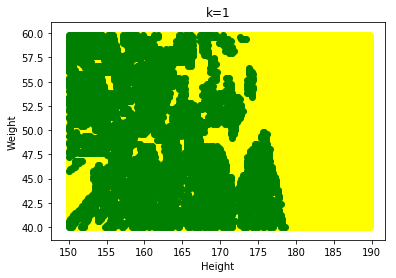

In [15]:
MyPic(0,1,1)

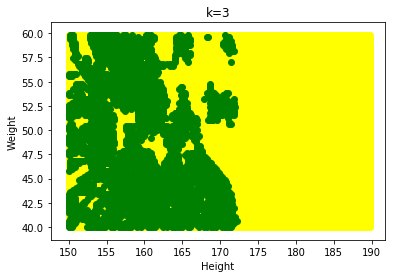

In [6]:
MyPic(0,1,3)

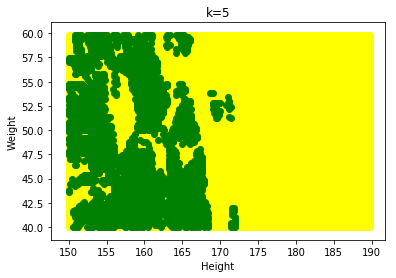

In [7]:
MyPic(0,1,5)

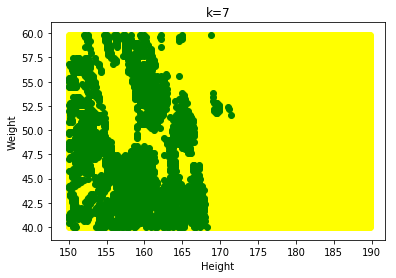

In [8]:
MyPic(0,1,7)

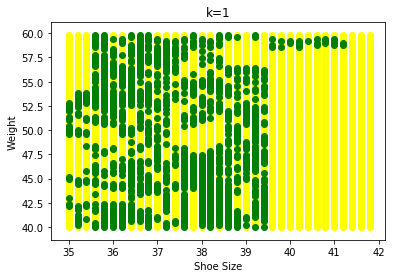

In [16]:
MyPic(2,1,1)

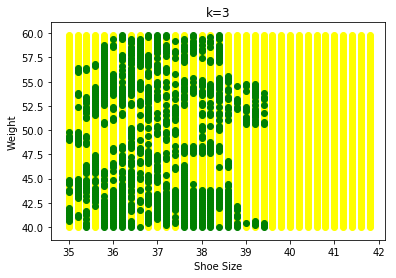

In [9]:
MyPic(2,1,3)

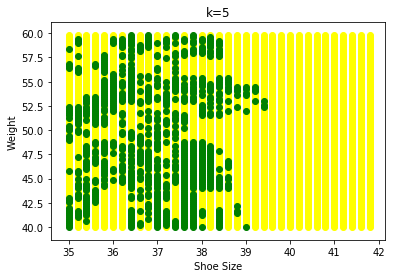

In [10]:
MyPic(2,1,5)

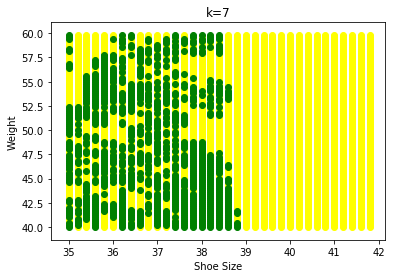

In [11]:
MyPic(2,1,7)

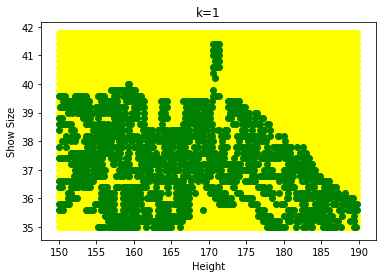

In [17]:
MyPic(0,2,1)

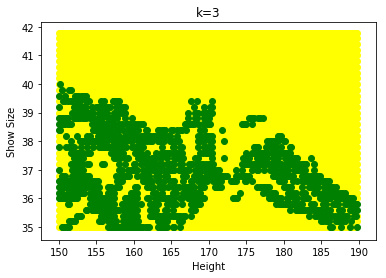

In [12]:
MyPic(0,2,3)

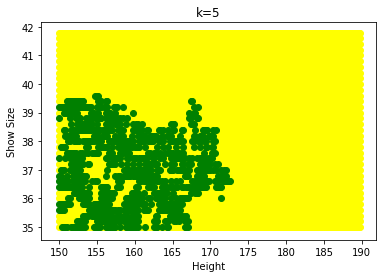

In [13]:
MyPic(0,2,5)

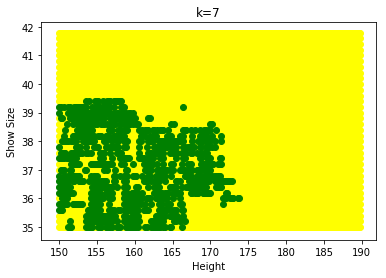

In [14]:
MyPic(0,2,7)